In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotx
import pandas as pd
from fastcore.xtras import load_pickle
from scipy.stats import sem

from gptchem.evaluator import find_learning_curve_intersection, fit_learning_curve, lc
from gptchem.settings import ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH

from gptchem.plotsettings import *

%matplotlib inline

## Load results

In [18]:
all_out = glob("out/**/*.pkl")

In [19]:
all_out = [load_pickle(p) for p in all_out]

In [20]:
all_out

[{'train_size': 50,
  'predictions': (#119) [1,1,1,1,1,1,1,0,1,0...],
  'xgboost': {'accuracy': 0.7983193277310925,
   'acc_macro': 0.7983193277310925,
   'racc': 0.6399971753407245,
   'kappa': 0.439780306002354,
   'confusion_matrix': pycm.ConfusionMatrix(classes: [0, 1]),
   'f1_macro': 0.7197802197802198,
   'f1_micro': 0.7983193277310925,
   'frac_valid': 1.0,
   'all_y_true': (#119) [1,1,1,1,0,1,1,1,1,0...],
   'all_y_pred': array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
          1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
          1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
          1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
          0, 1, 1, 1, 0, 1, 0, 1, 1]),
   'valid_indices': [0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17

In [21]:
extracted_res = []
xgboost_results = []
tabpfn_results = []
dummy_results = []

for out in all_out:
    res = {
        "train_size": out["train_size"],
        "frac_valid": out["frac_valid"],
        "accuracy": out["accuracy"],
        "f1_macro": out["f1_macro"],
        "f1_micro": out["f1_micro"],
        "kappa": out["kappa"],
    }

    xgb_res = {
        "train_size": out["train_size"],
        "accuracy": out["xgboost"]["accuracy"],
        "f1_macro": out["xgboost"]["f1_macro"],
        "f1_micro": out["xgboost"]["f1_micro"],
        "kappa": out["xgboost"]["kappa"],
    }

    tabpfn_res = {
        "train_size": out["train_size"],
        "accuracy": out["tabpfn"]["accuracy"],
        "f1_macro": out["tabpfn"]["f1_macro"],
        "f1_micro": out["tabpfn"]["f1_micro"],
        "kappa": out["tabpfn"]["kappa"],
    }


    extracted_res.append(res)
    xgboost_results.append(xgb_res)
    tabpfn_results.append(tabpfn_res)


In [22]:
res = pd.DataFrame(extracted_res)
xgboost_res = pd.DataFrame(xgboost_results)
tabpfn_res = pd.DataFrame(tabpfn_results)

In [23]:
grouped_res = res.groupby(["train_size"]).agg(["mean", "std", "count", sem])

In [24]:
grouped_xgboost_res = xgboost_res.groupby(["train_size"]).agg(["mean", "std", "count", sem])

In [25]:
grouped_tabpfn_res = tabpfn_res.groupby(["train_size"]).agg(["mean", "std", "count", sem])

In [26]:
grouped_res.loc[:]

frac_valid                  accuracy                            \
                 mean  std count  sem      mean       std count       sem   
train_size                                                                  
10                1.0  0.0     3  0.0  0.698113  0.098041     3  0.056604   
20                1.0  0.0     2  0.0  0.684564  0.113896     2  0.080537   
50                1.0  0.0     2  0.0  0.743697  0.017826     2  0.012605   
100               1.0  NaN     1  NaN  0.782609       NaN     1       NaN   
150               1.0  NaN     1  NaN  0.789474       NaN     1       NaN   

            f1_macro                            f1_micro                  \
                mean       std count       sem      mean       std count   
train_size                                                                 
10          0.422578  0.013041     3  0.007529  0.698113  0.098041     3   
20          0.474247  0.013389     2  0.009468  0.684564  0.113896     2   
50          0.599015  0.023417     2  0.016558  0.743697  0.017826     2   
100         0.701299       NaN     1       NaN  0.782609       NaN     1   
150         0.683333       NaN     1       NaN  0.789474       NaN     1   

                         kappa                            
                 sem      mean       std count       sem  
train_size                                                
10          0.056604 -0.060852  0.105399     3  0.060852  
20          0.080537 -0.001229  0.097789     2  0.069147  
50          0.012605  0.207671  0.047660     2  0.033701  
100              NaN  0.402770       NaN     1       NaN  
150              NaN  0.377049       NaN     1       NaN

In [27]:
grouped_tabpfn_res

accuracy                            f1_macro                  \
                mean       std count       sem      mean       std count   
train_size                                                                 
10          0.769392  0.003631     3  0.002096  0.503734  0.002146     3   
20          0.731544  0.009491     2  0.006711  0.555548  0.045001     2   
50          0.777311  0.029710     2  0.021008  0.567668  0.193813     2   
100         0.826087       NaN     1       NaN  0.731169       NaN     1   
150         0.789474       NaN     1       NaN  0.604167       NaN     1   

                      f1_micro                               kappa            \
                 sem      mean       std count       sem      mean       std   
train_size                                                                     
10          0.001239  0.769392  0.003631     3  0.002096  0.102838  0.007702   
20          0.031821  0.731544  0.009491     2  0.006711  0.133134  0.065188   
50          0.137046  0.777311  0.029710     2  0.021008  0.205810  0.291059   
100              NaN  0.826087       NaN     1       NaN  0.468549       NaN   
150              NaN  0.789474       NaN     1       NaN  0.269231       NaN   

                            
           count       sem  
train_size                  
10             3  0.004447  
20             2  0.046095  
50             2  0.205810  
100            1       NaN  
150            1       NaN

In [28]:
grouped_xgboost_res

accuracy                                f1_macro                  \
                mean       std count           sem      mean       std count   
train_size                                                                     
10          0.754717  0.000000     3  7.850462e-17  0.430108  0.000000     3   
20          0.758389  0.000000     2  0.000000e+00  0.431298  0.000000     2   
50          0.802521  0.005942     2  4.201681e-03  0.707445  0.017445     2   
100         0.855072       NaN     1           NaN  0.812092       NaN     1   
150         0.789474       NaN     1           NaN  0.683333       NaN     1   

                      f1_micro                                   kappa  \
                 sem      mean       std count           sem      mean   
train_size                                                               
10          0.000000  0.754717  0.000000     3  7.850462e-17  0.000000   
20          0.000000  0.758389  0.000000     2  0.000000e+00  0.000000   
50          0.012335  0.802521  0.005942     2  4.201681e-03  0.419055   
100              NaN  0.855072       NaN     1           NaN  0.624592   
150              NaN  0.789474       NaN     1           NaN  0.377049   

                                     
                std count       sem  
train_size                           
10          0.00000     3  0.000000  
20          0.00000     2  0.000000  
50          0.02931     2  0.020726  
100             NaN     1       NaN  
150             NaN     1       NaN

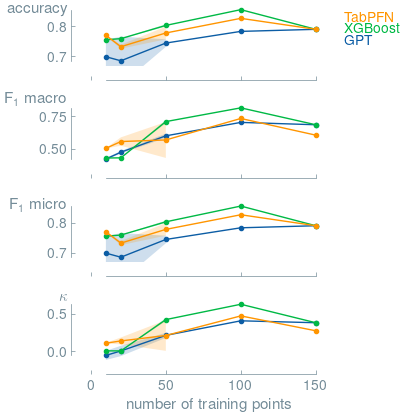

In [32]:
# with plt.style.context(matplotx.styles.dufte):
fig, ax = plt.subplots(
    4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH), sharex="all"
)

# plot the binary case, i.e. num_classes = 2

for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
    ax[i].plot(
        grouped_res.loc[ :].index,
        grouped_res.loc[:][metric]["mean"],
        marker="o",
        label="GPT",
    )
    ax[i].fill_between(
        grouped_res.loc[ :].index,
        grouped_res.loc[:][metric]["mean"] - grouped_res.loc[ :][metric]["sem"],
        grouped_res.loc[ :][metric]["mean"] + grouped_res.loc[ :][metric]["sem"],
        alpha=0.2,
    )

    range_frame(
        ax[i],
        grouped_res.loc[ :].index,
        np.stack([
            grouped_res.loc[:][metric]["mean"],
              grouped_xgboost_res.loc[ :][metric]["mean"],
              grouped_tabpfn_res.loc[ :][metric]["mean"], 
        ]).flatten()
    )

    ax[i].plot(
        grouped_xgboost_res.loc[ :].index,
        grouped_xgboost_res.loc[ :][metric]["mean"],
        marker="o",
        label="XGBoost",
    )
    ax[i].fill_between(
        grouped_xgboost_res.loc[ :].index,
        grouped_xgboost_res.loc[:][metric]["mean"]
        - grouped_xgboost_res.loc[ :][metric]["sem"],
        grouped_xgboost_res.loc[:][metric]["mean"]
        + grouped_xgboost_res.loc[:][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_tabpfn_res.loc[ :].index,
        grouped_tabpfn_res.loc[ :][metric]["mean"],
        marker="o",
        label="TabPFN",
    )
    ax[i].fill_between(
        grouped_tabpfn_res.loc[ :].index,
        grouped_tabpfn_res.loc[:][metric]["mean"]
        - grouped_tabpfn_res.loc[ :][metric]["sem"],
        grouped_tabpfn_res.loc[ :][metric]["mean"]
        + grouped_tabpfn_res.loc[:][metric]["sem"],
        alpha=0.2,
    )

ylabel_top("accuracy", ax=ax[0], x_pad=0.05, y_pad=0.06)
ylabel_top(r"F$_{1}$ macro", ax=ax[1], x_pad=0.05, y_pad=0.06)
ylabel_top(r"F$_{1}$ micro", ax=ax[2], x_pad=0.05, y_pad=0.06)
ylabel_top(r"$\kappa$", ax=ax[3], x_pad=0.05, y_pad=0.06)
ax[-1].set_xlabel("number of training points", labelpad=4)
matplotx.line_labels(ax=ax[0])
plt.subplots_adjust(hspace=.6, top=1, bottom=.2)

fig.savefig("mof_water_stability.pdf", bbox_inches="tight")

In [15]:
find_learning_curve_intersection(
    grouped_res.loc[2, :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_xgboost_res.loc[2, :].index,
        grouped_xgboost_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / 10

KeyError: 2

In [ ]:
find_learning_curve_intersection(
    grouped_res.loc[2, :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_tabpfn_res.loc[2, :].index,
        grouped_tabpfn_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / 10

KeyError: 2